In [1]:
import pandas as pd; pd.set_option('max_columns', 5)  # Unclutter display.
import geopandas as gpd
import geoplot as gplt
# for some reason choropleth raises an error if any projection is used 
import geoplot.crs as gcrs 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import numpy as np
import gc

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['font.monospace'] = ['Courier Prime','Courier New','Roboto Mono', 'Ubuntu Mono']

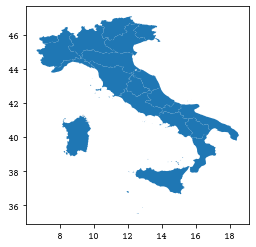

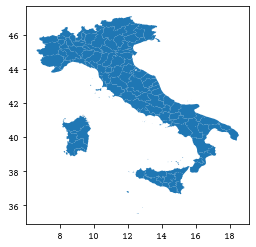

In [8]:
file_name_re = 'limits_IT_regions.geojson.txt'
file_name_prov = 'limits_IT_provinces.geojson.txt'
df_map_re = gpd.read_file(os.path.join(os.getcwd(),'Data',file_name_re))
df_map_prov = gpd.read_file(os.path.join(os.getcwd(),'Data',file_name_prov))
df_map_re.plot()
df_map_prov.plot()

In [10]:
df = pd.read_csv(os.path.join(os.getcwd(),'Data','dpc-covid19-ita-province.csv'), sep=',',header=0)
df_ita = pd.read_csv(os.path.join(os.getcwd(),'Data','dpc-covid19-ita-andamento-nazionale.csv'), sep=',',header=0)
df_reg = pd.read_csv(os.path.join(os.getcwd(),'Data','dpc-covid19-ita-regioni.csv'), sep=',',header=0)
df_ita['data'] = pd.to_datetime(df_ita['data'], format="%Y-%m-%d").dt.date
date_list_repeat = df['data'].to_list()
date_list_re_repeat = df_reg['data'].to_list()
date_list = []
date_list_re = []
[date_list.append(x) for x in date_list_repeat if x not in date_list]
[date_list_re.append(x) for x in date_list_re_repeat if x not in date_list_re]
date_list = date_list[1:]
date_list_re = date_list_re[1:]
for i in range(len(date_list_re)):
    print(date_list[i],'\t', date_list_re[i] )

2020-02-25 18:00:00 	 2020-02-25 18:00:00
2020-02-26 18:00:00 	 2020-02-26 18:00:00
2020-02-27 18:00:00 	 2020-02-27 18:00:00
2020-02-28 18:00:00 	 2020-02-28 18:00:00
2020-02-29 17:00:00 	 2020-02-29 17:00:00
2020-03-01 17:00:00 	 2020-03-01 17:00:00
2020-03-02 17:00:00 	 2020-03-02 18:00:00
2020-03-03 17:00:00 	 2020-03-03 18:00:00
2020-03-04 17:00:00 	 2020-03-04 17:00:00
2020-03-05 17:00:00 	 2020-03-05 17:00:00
2020-03-06 18:00:00 	 2020-03-06 17:00:00
2020-03-07 18:00:00 	 2020-03-07 18:00:00
2020-03-08 18:00:00 	 2020-03-08 18:00:00


In [7]:
def get_daily_df(index, dataframe):
    df_data = dataframe[dataframe.data == index].copy()
    df_data.sort_values('codice_provincia', inplace=True)
    data_merged = pd.merge(df_map_prov, df_data.rename(columns={"codice_provincia": "prov_istat_code_num"}), on='prov_istat_code_num', how='left')
    data_merged.drop(['prov_istat_code','reg_istat_code_num','lat','long','prov_name','denominazione_regione','prov_acr','reg_name','reg_istat_code'], axis=1,inplace=True)
    #data_merged['Value'].fillna(0, inplace=True)
    return data_merged

df_new = get_daily_df(date_list[2], df)
print(df_new.head())

   prov_istat_code_num                                           geometry  \
0                    1  POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...   
1                    2  POLYGON ((7.92900 45.74244, 7.92584 45.74196, ...   
2                    3  POLYGON ((8.42079 45.82981, 8.42028 45.83010, ...   
3                    4  MULTIPOLYGON (((6.94540 44.42794, 6.94734 44.4...   
4                    5  POLYGON ((7.96685 45.11667, 7.96729 45.11673, ...   

   ...  sigla_provincia totale_casi  
0  ...               TO           2  
1  ...               VC           0  
2  ...               NO           0  
3  ...               CN           0  
4  ...               AT           0  

[5 rows x 9 columns]


In [11]:
def return_ylims(ylims):
    ymax = (divmod(ylims,10**(len(str(int(ylims)))-1))[0]+1)*10**(len(str(int(ylims)))-1) #fancy way of runding to the decade
    if ymax < 10:
        return (0,10)
    else:
        return (0,int(ymax))





def generate_pngs(date_limit, date, date_re, df, df_ita, df_rg):
    fig = plt.figure(figsize=(12,16), dpi=150,constrained_layout=True)
    gs = fig.add_gridspec(2,3,**{'height_ratios': [4,1], 'hspace':0.1, 'wspace': 0.3  })
    gs1 = gs[1].subgridspec(1, 3)
    df_prov = get_daily_df(date, df)

    #map plotting to ax1 ------------------------------------------------------------------
    ax1 = fig.add_subplot(gs[0,:], projection=gcrs.EuroPP())
    plt.text(1, 0, 'r/etrevis     github.com/etrevis \nfonte: protezionecivile.gov.it', color='tab:gray',fontsize=12, rotation=90, transform=ax1.transAxes)
    plt.text(0.075, 0.17, str('Data: {}/{}/{}'.format(date[8:10],date[5:7],date[:4])), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    cax = fig.add_axes([0.7,0.65,0.015,0.2])
    
    gplt.choropleth(df_prov,
                    extent = (6.8,36.6,18.2,47),
                    ax=ax1,
                    figsize = (12,12),
                    hue='totale_casi',
                    cmap=cmap.cmap,
                    norm = norm,
                    edgecolor='black',
                    linewidth=0.4,
                   )
    cbar = plt.gcf().colorbar(cmap, ax=ax1, cax = cax, **{'extend': 'max'})

    cbar.outline.set_linewidth(1)
    cbar.set_label('Totale positivi', rotation=90, labelpad=-80, size=20)
    cbar.ax.tick_params(labelsize=24, labelcolor = 'black', width=1)

    #custom ax2 general ----------------------------------------------------------------------
    marker_style = dict(linestyle=':', linewidth=1.5, marker='o', markersize=6)    
    
    #total plot to ax2
    ax2 = fig.add_subplot(gs[1,0])
    date_axis = df_ita['data'].iloc[1:(date_limit+2)]   

    
    label_list = [['Totale:   ', 'totale_casi'],
                  ['Positivi: ', 'totale_attualmente_positivi'],
                  ['Dimessi:  ', 'dimessi_guariti'],
                  ['Decessi:  ','deceduti' ]
                 ]    
    label_colors = plt.get_cmap('viridis_r')(np.linspace(0, 0.8,(len(label_list)+1)))

    for label, color in zip(label_list, label_colors):
        plt.plot(date_axis,
                 df_ita[label[1]].iloc[1:(date_limit+2)],
                 label=(label[0]+str(int(df_ita[label[1]].iloc[date_limit+1]))),
                 color=color,
                 **marker_style)

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_linewidth(line_wd)
    ax2.spines['left'].set_linewidth(line_wd)
    ax2.tick_params(labelsize=labels_sz, labelcolor = 'black', width=1)
    ax2.legend(**dict(fontsize=labels_sz, markerscale=0.5, frameon=False, loc='center', bbox_to_anchor=(0.5, 1.45)))
    
    # Y-axis
    plt.ylim(return_ylims(int(df_ita['totale_casi'].max())))   #or ax2.get_ylim()
    ax2.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=5))
    
    #X- Axis
    ax2.set_xlim(left=df_ita['data'][1],
                    right=datetime(2020,
                                    int(df_ita['data'][len(df_ita['data'])-1].month),
                                    (int(df_ita['data'][len(df_ita['data'])-1].day)+1)))
    ax2.set_xmargin(0.05)
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%m'))
    ax2.xaxis.set_tick_params(rotation=70)
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    
    
    #histrogram regions ax4 -----------------------------------------------------------------------------
    data_reg = df_rg[df_rg.data==date_re].copy()
    data_reg.drop_duplicates('totale_casi', inplace=True)
    data_reg.sort_values(by=['totale_casi'], inplace=True, ascending=False)
    data_reg_hist = data_reg.iloc[:6]          # get top six regions
    data_reg_hist.set_index('denominazione_regione', inplace=True)    
    x_ind = np.arange(len(data_reg_hist.index.to_list()))
    name_list = [(x[:4]+'.') for x in data_reg_hist.index.to_list()]
    
    label_list_reg = [['Ospedaliz.', 'totale_ospedalizzati'],
                      ['Autoisolam.', 'isolamento_domiciliare'],
                      ['Dimessi', 'dimessi_guariti'],
                      ['Decessi','deceduti' ]
                     ]
 
    df_data_reg = []
    store_y_top = [0 for i in range(len(x_ind))]
    for label in label_list_reg:
        y_bottom = store_y_top
        y_top = []
        for region in data_reg_hist.index:
            new_y = int(data_reg_hist[data_reg_hist.index == region][label[1]])
            y_top.append(new_y)
        for i in range(len(store_y_top)):
            y_top[i] += y_bottom[i]
        store_y_top = y_top
        df_data_reg.append(pd.DataFrame({'x': [i for i in range(len(x_ind))], 'y_bottom': y_bottom, 'y_top': y_top}))
           

    label_colors_reg = plt.get_cmap('YlOrRd')(np.linspace(0.1, 1,(len(label_list_reg)+1)))

    
    ax4 = fig.add_subplot(gs[1,1])    
    
    #for some reason iterating over the zipped lists and using the bottomparameter does not work in my env
    
    ax4.bar(df_data_reg[3]['x'], df_data_reg[3]['y_top'],
            #bottom=df_data_reg[3]['y_bottom'],
            label=label_list_reg[3][0], width=0.95, align='center', color=label_colors_reg[3]) 
    ax4.bar(df_data_reg[2]['x'], df_data_reg[2]['y_top'],
            #bottom=df_data_reg[2]['y_bottom'],
            label=label_list_reg[2][0], width=0.95, align='center', color=label_colors_reg[2])
    ax4.bar(df_data_reg[1]['x'], df_data_reg[1]['y_top'],
            #bottom=df_data_reg[1]['y_bottom'],
            label=label_list_reg[1][0], width=0.95, align='center', color=label_colors_reg[1])
    ax4.bar(df_data_reg[0]['x'], df_data_reg[0]['y_top'],
            #bottom=df_data_reg[0]['y_bottom'],
            label=label_list_reg[0][0], width=0.95, align='center', color=label_colors_reg[0])


    ax4.legend(**dict(fontsize=(labels_sz-6), markerscale=0.2, frameon=False, loc='center', bbox_to_anchor=(0.65, 0.8)))    
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['bottom'].set_linewidth(line_wd)
    ax4.spines['left'].set_linewidth(line_wd)
    ax4.tick_params(labelsize=labels_sz, labelcolor = 'black', width=1)
    plt.xticks(x_ind, name_list)
    plt.ylim(return_ylims(df_rg['totale_casi'].max()))
    ax4.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=5))
    ax4.xaxis.set_tick_params(rotation=70)
    
    
    
    #histogram to ax3 --------------------------------------------------------------------------------
    df_prov_ = df_prov.drop_duplicates('totale_casi')
    df_prov_.sort_values(by=['totale_casi'], inplace=True, ascending=False)
    df_prov_hist = df_prov_.iloc[:8]    
    color_list = [cmap.to_rgba(x) for x in df_prov_hist['totale_casi'].to_list()]
    x_ind = np.arange(len(df_prov_hist['sigla_provincia'].to_list()))

    ax3 = fig.add_subplot(gs[1,2])
    ax3.bar(x_ind, df_prov_hist['totale_casi'], width=0.95, align='center', color=color_list)
    
    plt.ylim(return_ylims(df['totale_casi'].max()))
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_linewidth(line_wd)
    ax3.spines['left'].set_linewidth(line_wd)
    ax3.tick_params(labelsize=labels_sz, labelcolor = 'black', width=1)
    ax3.yaxis.set_major_locator(mpl.ticker.LinearLocator(numticks=5))
    plt.xticks(x_ind, df_prov_hist['sigla_provincia'].to_list())
    ax3.xaxis.set_tick_params(rotation=70)
    
    plt.savefig(os.path.join(os.getcwd(),'Figs',str(date_limit)+'.png'),dpi=300, bbox_inches='tight')
    plt.close(fig)
    del date_axis, df_prov_, df_prov_hist, df_data_reg, data_reg
    gc.collect()

In [5]:

map_col = 'YlOrBr'
limits = [0,10000]
line_wd = 2
labels_sz = 20
norm = mpl.colors.SymLogNorm(linthresh=1,vmin=limits[0], vmax=limits[1])
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=map_col)


In [12]:
generate_pngs(12, date_list[12], date_list_re[12], df, df_ita, df_reg)

C:\Users\etrev\Anaconda3\envs\general-maps\lib\site-packages\geoplot\geoplot.py:591: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
C:\Users\etrev\Anaconda3\envs\general-maps\lib\site-packages\geoplot\geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None
<ipython-input-11-d5fbf71e5f41>:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prov_.sort_values(by=['totale_casi'], inplace=True, ascending=False)
<ipython-input-11-d5fbf71e5f41>:167: UserWarning: constrained_layo